In [1]:
library(ggplot2)
library(reshape2)
library(sqldf)
library(fields)
library(gridExtra)
library(ggtern)
library(clue)
library(geometry)
library(gtable)
library(goseq)

Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite
Loading required package: spam
Loading required package: grid
Spam version 1.4-0 (2016-08-29) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps
--
Consider donating at: http://ggtern.com
Even small amounts (say $10-50) are very much appreciated!
Remember to cite, run citation(package = 'ggtern') for further info.
--

Attaching package: ‘ggtern’

The following objects are masked from ‘package:gridExtra’:

    arrangeGrob, grid.arrange

The following objects are masked from ‘package:ggplot2’:

    %+%, aes, annotate, calc_element, ggplot, ggplot_build,
    ggplot_gtable, ggplot

In [2]:
folder<-"/Users/ramirezr/Dropbox/JIC/expVIPMetadatas/RefSeq1.0/TablesForExploration"

loadGeneInformation<-function(dir="../TablesForExploration"){
    path<-paste0(dir,"/CanonicalTranscript.rds")
    canonicalTranscripts<-readRDS(path)
    canonicalTranscripts$intron_length<- canonicalTranscripts$mrna_length -  canonicalTranscripts$exon_length
    canonicalTranscripts$chr_group <- substr(canonicalTranscripts$Chr,4,4)
    canonicalTranscripts$genome    <- substr(canonicalTranscripts$Chr,5,5)
    
    path<-paste0(dir, "/MeanTpms.rds")
    meanTpms <- readRDS(path)
    expressed_genes<-unique(meanTpms$gene)
    canonicalTranscripts<-canonicalTranscripts[canonicalTranscripts$Gene %in% expressed_genes, ]
    
    
    path<-paste0(dir,"/TriadMovement.rds")
    triadMovement<-readRDS(path)
    
    path<-paste0(dir,"/Triads.rds")
    triads<-readRDS(path)
    
    path<-paste0(dir,"/universe_table.csv")
    gene_universe<-read.csv(path)
    
    path<-paste0(dir, "/OntologiesForGenes.rds")
    ontologies<-readRDS(path)
    
    path<-paste0(dir, "/id_names_merged.txt")
    id_names <- read.csv(path, header=F, sep = "\t")
    
    path<-paste0(dir, "/WGCNA_table.csv")
    WGCNA <-  read.csv(path)
    
    list(canonicalTranscripts=canonicalTranscripts, 
         meanTpms=meanTpms,
         triads=triads, 
         triadMovement=triadMovement,
         gene_universe=gene_universe, 
         ontologies=ontologies,
         id_names=id_names,
         WGCNA=WGCNA
        )
}
geneInformation<-loadGeneInformation()

In [3]:

#genes_to_plot<-subset(geneInformation$WGCNA, ModuleLabels == 15 & set == "WGCNA_850")
genes_to_plot<-geneInformation$canonicalTranscripts[sample(nrow(geneInformation$canonicalTranscripts), 1000), ]
genes_to_plot<-genes_to_plot$Gene
head(genes_to_plot)
class(genes_to_plot)
nrow(genes_to_plot)

[1] TraesCS7A01G345900   TraesCS2A01G384800   TraesCS1D01G417700  
[4] TraesCS5B01G525400LC TraesCS7D01G108800   TraesCS1A01G115700  
269583 Levels: TraesCS1A01G000100 TraesCS1A01G000100LC ... TraesCSU01G669200LC

[1] "factor"

NULL

,Gene,transcript,Chr,Start,End,mrna_length,geneconf,size_cds,exon_no,exon_length,scaled_1per_position,scaled_5per_position,X3UTR_length,X5UTR_length,intron_length,chr_group,genome
171,TraesCS1A01G008600,TraesCS1A01G008600.1,chr1A,5023872,5029289,5417,HC,1638,7,1853,1,0,215,0,3564,1,A
386,TraesCS1A01G019300LC,TraesCS1A01G019300LC.1,chr1A,8225482,8225767,285,LC,285,1,285,1,0,0,0,0,1,A
1079,TraesCS1A01G054000,TraesCS1A01G054000.1,chr1A,35542717,35543825,1108,HC,882,1,1108,6,5,185,41,0,1,A
1401,TraesCS1A01G070100,TraesCS1A01G070100.1,chr1A,52559622,52563522,3900,HC,663,4,3288,9,5,2020,605,612,1,A
1477,TraesCS1A01G073900,TraesCS1A01G073900.1,chr1A,57634277,57635926,1649,HC,951,5,1193,10,10,188,54,456,1,A
1544,TraesCS1A01G077200LC,TraesCS1A01G077200LC.1,chr1A,35214615,35215101,486,LC,486,1,486,6,5,0,0,0,1,A


Warning message:
“Removed 6526 rows containing non-finite values (stat_bin).”Warning message:
“Removed 1 rows containing missing values (geom_vline).”

[1] 1000

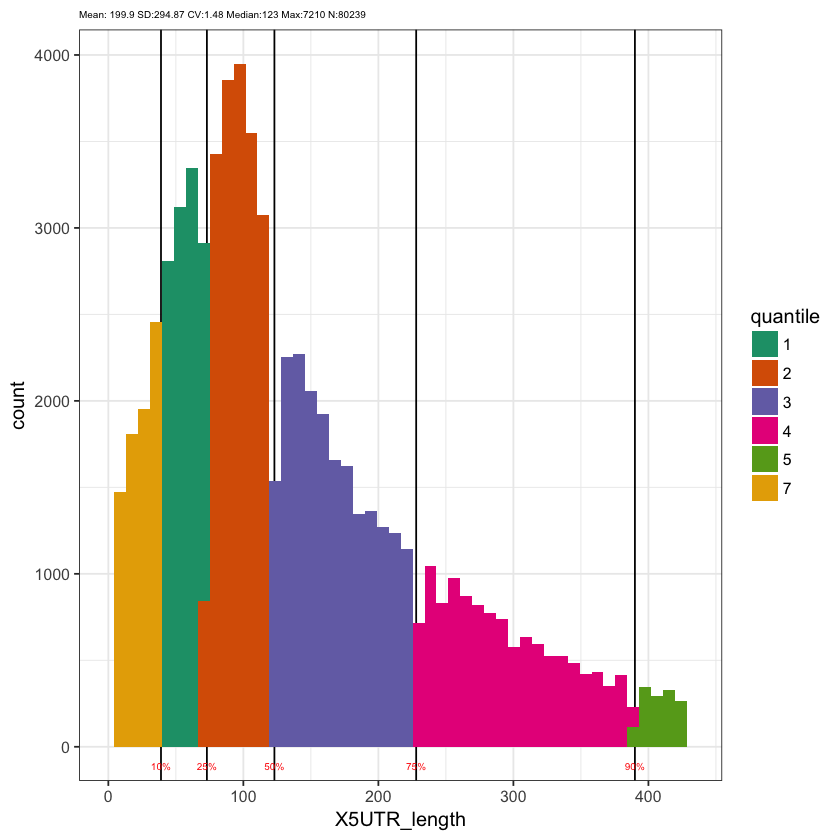

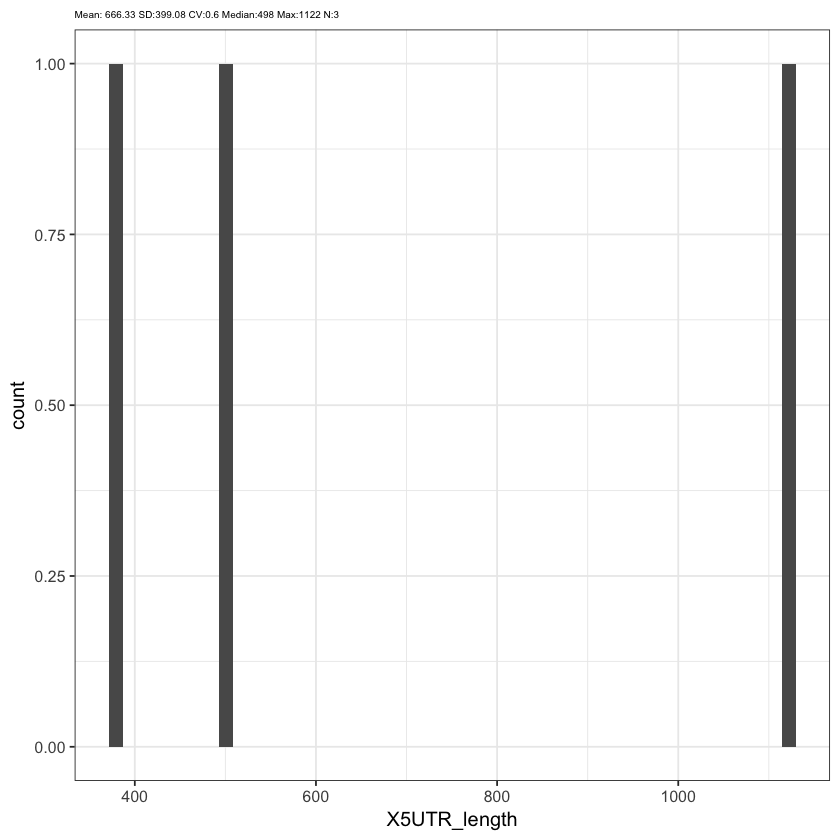

In [4]:
plotHistogram<-function(table, column="size_cds"){
    table<-table[table[,column]>0,]
    
    probs <- c( 0.1, 0.25, 0.5, 0.75, 0.9, 0.95)
    quantiles <- data.frame(quantile(table[,column], prob=probs,na.rm=TRUE, include.lowest=TRUE), stringsAsFactors=FALSE)
    quantiles$quant<-rownames(quantiles)
    colnames(quantiles)<-c("value", "quant")
    values<-quantiles$values
    local_mean<-mean(table[,column])
    local_sd<-sd(table[,column])
    local_max <-  max(table[,column])
    p <- ggplot(table, aes_string(column))
    
    if(nrow(table) > 100){
       table <- within(table,
                       quantile <- as.integer(
                           cut(table[,column],
                               unique(quantile(table[,column], 
                                    prob=probs,
                                    na.rm=TRUE, 
                                    include.lowest=TRUE))
                              )
                       ))
    
        table$quantile<-ifelse(is.na(table$quantile),7,table$quantile)
        table$quantile<-as.factor(table$quantile)
    
        iq <- quantiles$value[4] - quantiles$value[2]
    
        xmax <- quantiles$value[3] + (iq * 2)
        xmin <- quantiles$value[3] - (iq * 2)
        if(xmin < 0){
            xmin <- 0
        }
    
        if(xmax > local_max){
            xmax <- local_max + 1
        }
        
        p <- ggplot(table, aes_string(column, fill="quantile"))
        p <- p + geom_vline(data=quantiles,aes(xintercept=quantiles$value) )
        for(i in seq(1,nrow(quantiles))){
            x_pos<-quantiles$value[i]
             gtext <- textGrob(quantiles$quant[i], y=0.02,  gp = gpar(fontsize = 6,col = "red"))
             p <- p + annotation_custom(gtext, xmin=x_pos, xmax=x_pos)
        }
        p <- p  + xlim(xmin, xmax) +
        scale_fill_brewer(palette="Dark2")
    
    }
    
    
    
    
    p<- p + geom_histogram(bins=50, position = "identity") + theme_bw() 
    theme(legend.position="none")
    p<- p + ggtitle(paste0("Mean: ", round(local_mean,2), 
                           " SD:", round(local_sd,2),
                           " CV:", round(local_sd/local_mean, 2), 
                           " Median:", round(median(table[,column],2)),
                           " Max:", round(local_max,2),
                           " N:", nrow(table))) 
    
    p <- p + theme(plot.title = element_text(size=6))
    p
}
local_table<-geneInformation$canonicalTranscripts
local_table<-local_table[local_table$Gene %in% genes_to_plot,]
head(local_table)
plotHistogram(geneInformation$canonicalTranscripts, column="X5UTR_length")
nrow(local_table)
plotHistogram(head(geneInformation$canonicalTranscripts), column="X5UTR_length")

In [5]:
head(geneInformation$meanTpms)

value,factor,gene,samples,subset,min_mean_tpm
35.3429709,all,TraesCS1A01G000100,128,spike,0.5
778.7933277,all,TraesCS1A01G000100LC,128,spike,0.5
150.7084593,all,TraesCS1A01G000200,128,spike,0.5
0.2557844,all,TraesCS1A01G000200LC,128,spike,0.5
18.7230705,all,TraesCS1A01G000300,128,spike,0.5
3.2775778,all,TraesCS1A01G000300LC,128,spike,0.5


Warning message:
“Removed 9 rows containing non-finite values (stat_count).”Warning message:
“Removed 21 rows containing missing values (geom_point).”

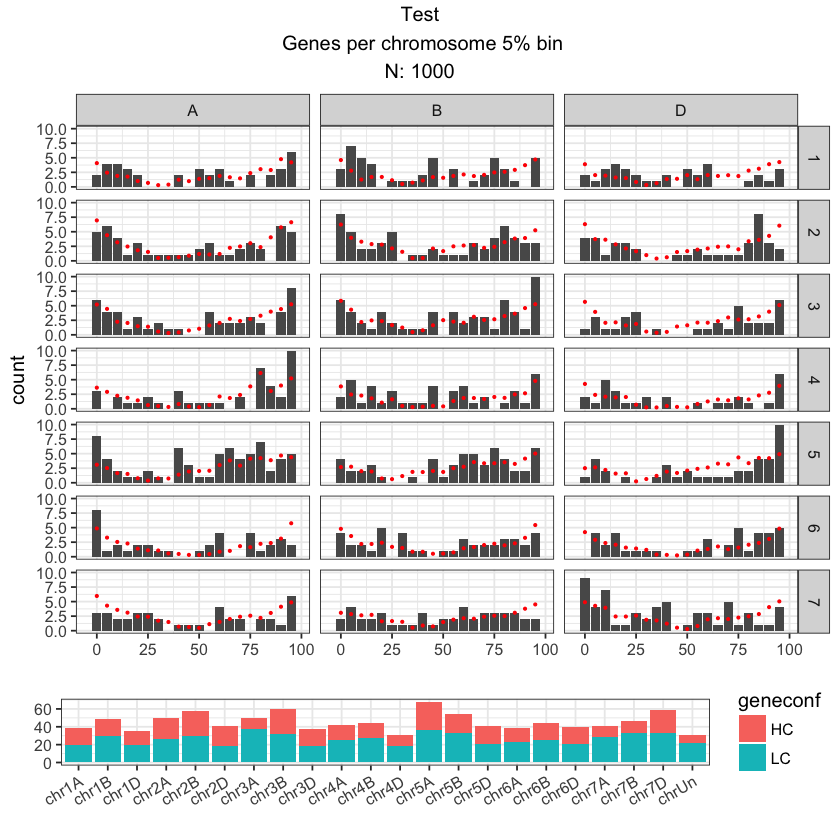

In [6]:
get_expected_values<-function(gene_table, numberOfGenes){
    #Make this only tge HC genes
   
    counts<-sqldf("SELECT Chr, chr_group, genome,scaled_5per_position, count(*) as count FROM
gene_table WHERE geneconf = 'HC' GROUP BY Chr, chr_group, genome, scaled_5per_position ")
    multiplier <- numberOfGenes / sum(counts$count)
    counts$expected <- counts$count * multiplier
    counts
}

plot_per_chromosome_5pc_bins_facet<-function(table,expected_per_chr, title = "Test"){
    chromosomes=c("1A", "1B", "1D",
                "2A", "2B", "2D",
                "3A", "3B", "3D",
                "4A", "4B", "4D",
                "5A", "5B", "5D",
                "6A", "6B", "6D",
                  
                "7A", "7B", "7D")
    
    
    gs<-list()
    local_title = paste0(title, "\n Genes per chromosome 5% bin\nN: ", nrow(table) )
    
    t1 <- table[table$Chr != "chrUn",]
    
    expected_per_chr <- expected_per_chr[expected_per_chr$Chr != "chrUn",]
    p <-ggplot(t1,aes(scaled_5per_position)) 
    
    p <- p + xlim(-5,99)
    p <- p + geom_bar() + theme_bw()
    p <- p + facet_grid(chr_group~genome,  drop = TRUE)
    p <- p + ylab(" count ") + xlab("")
    p <- p + geom_point(data=expected_per_chr, 
                        aes(x=scaled_5per_position, y=expected), color="red", size = 0.5)
    
    gs[[length(gs)+1]] <- p
    
    p <-ggplot(table,aes(Chr, fill=geneconf))  + geom_bar() + theme_bw()
    p <- p + theme(axis.text.x = element_text(angle = 30, hjust = 1)) + ylab("") + xlab("")
    gs[[length(gs)+1]] <- p
    
    g1<-arrangeGrob(grobs=gs, ncol=1, heights=c(0.8,0.2), top=local_title ) 
}

expected_per_chr<-get_expected_values(geneInformation$canonicalTranscripts, nrow(local_table))
g<-plot_per_chromosome_5pc_bins_facet(local_table, expected_per_chr)

grid.draw(g)

In [7]:
head(expected_per_chr)

Chr,chr_group,genome,scaled_5per_position,count,expected
chr1A,1,A,0,452,4.0797906
chr1A,1,A,5,271,2.4460691
chr1A,1,A,10,209,1.8864518
chr1A,1,A,15,196,1.7691127
chr1A,1,A,20,111,1.0018955
chr1A,1,A,25,76,0.6859825


[1] TraesCS7A01G345900   TraesCS2A01G384800   TraesCS1D01G417700  
[4] TraesCS5B01G525400LC TraesCS7D01G108800   TraesCS1A01G115700  
269583 Levels: TraesCS1A01G000100 TraesCS1A01G000100LC ... TraesCSU01G669200LC

Warning message:
“Removed 1329 rows containing non-finite values (stat_bin).”Warning message:
“Removed 61 rows containing non-finite values (stat_bin).”

value,factor,gene,samples,subset,min_mean_tpm
35.3429709,all,TraesCS1A01G000100,128,spike,0.5
778.7933277,all,TraesCS1A01G000100LC,128,spike,0.5
150.7084593,all,TraesCS1A01G000200,128,spike,0.5
0.2557844,all,TraesCS1A01G000200LC,128,spike,0.5
18.7230705,all,TraesCS1A01G000300,128,spike,0.5
3.2775778,all,TraesCS1A01G000300LC,128,spike,0.5


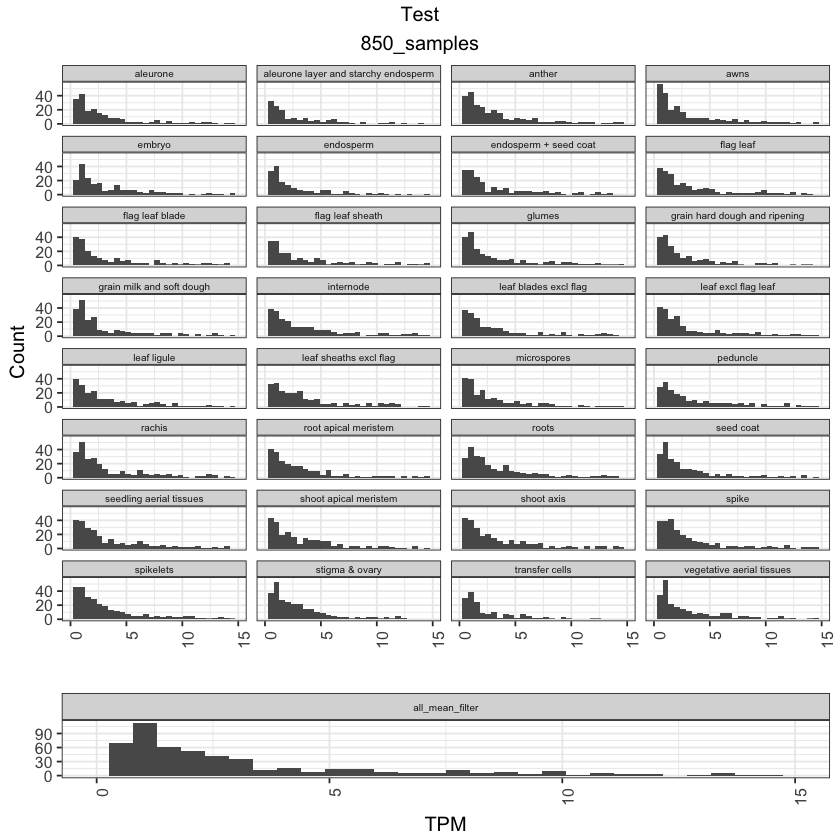

In [8]:
plot_tpms_summary<-function(tpms, experiment="850_samples", min_tpm=0.5, title="Test"){
    
    local_tpms<-subset(tpms, (subset == experiment) & 
                       ( factor != "all" & factor != "all_means" & factor != "all_mean_filter" ) &
                      value > min_tpm)
   
    local_title <- paste0(title, "\n", experiment)
    
    p  <- ggplot(local_tpms, aes(value)) 
    p  <- p + geom_histogram(bins=30 ) + theme_bw()
    p  <- p + theme(axis.text.x = element_text(angle = 90, hjust = 1), 
                      strip.text = element_text(size=6))
    p  <- p + facet_wrap(~ factor, ncol=4) 
    p  <- p + xlim(0,15) 
    p  <- p + ylab("Count") + xlab("")
    p  <- p + theme(strip.text.x = element_text(margin = margin(.1, 0, .1, 0, "cm")))

    
    local_tpms<-subset(tpms, (subset == experiment) & 
                       ( factor == "all_mean_filter" ) &
                      value > min_tpm)
    
    p2  <- ggplot(local_tpms, aes(value)) 
    p2  <- p2 + geom_histogram(bins=30 ) + theme_bw()
    p2  <- p2 + theme(axis.text.x = element_text(angle = 90, hjust = 1), 
                      strip.text = element_text(size=6, lineheight=0.5))
    p2  <- p2 + facet_wrap(~ factor, ncol=1)  + xlim(0,15)
    p2  <- p2 + ylab("") + xlab("TPM") 
        
    mytheme <- gridExtra::ttheme_default(
    core = list(fg_params=list(cex = 0.5)),
    colhead = list(fg_params=list(cex = 0.5)),
    rowhead = list(fg_params=list(cex = 0.5)))
    
   
    
    lay <- rbind(c(1),
                 c(2))
    g1<-arrangeGrob(grobs=list(p,p2), heights=c(0.8,0.2), layout_matrix=lay, top = local_title) 
    g1
}
local_tpms<-geneInformation$meanTpms
head(genes_to_plot)
local_tpms<-local_tpms[local_tpms$gene %in% genes_to_plot,]
g<-plot_tpms_summary(local_tpms)
head(geneInformation$meanTpms)
grid.draw(g)

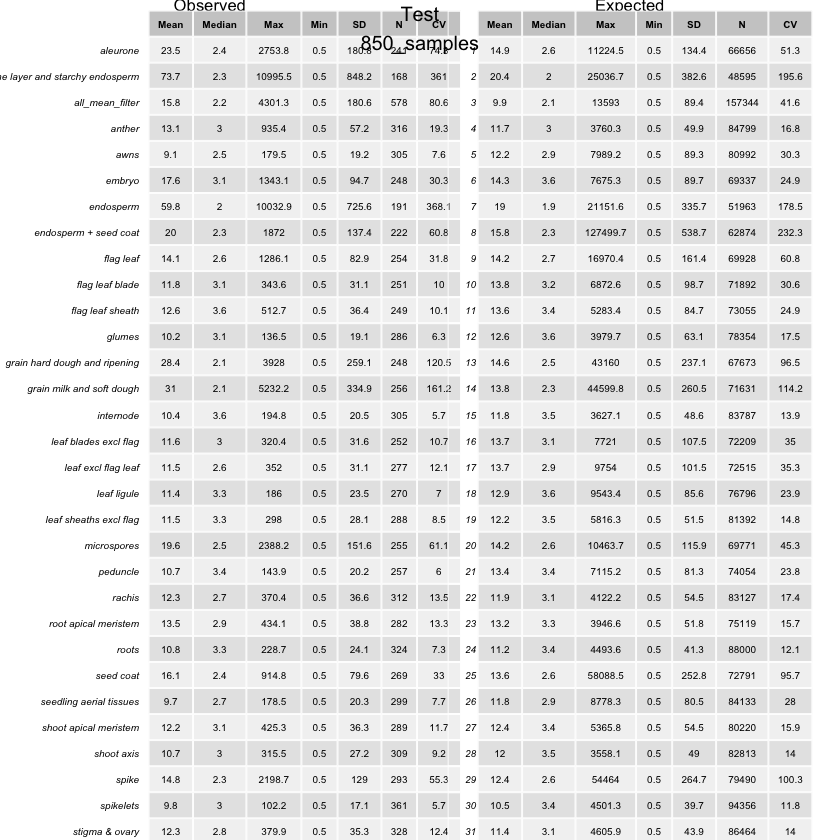

In [9]:
get_tpms_desc_stats<-function(tpms, min_tpm=0.5, experiment="850_samples"){
    
    
    local_tpms<-subset(tpms, (subset == experiment) & 
                        factor != "all" &
                       factor != "all_means"  &
                      value > min_tpm)
    
    factor_means <- aggregate(value ~ factor, data = local_tpms, mean)
    factor_max   <- aggregate(value ~ factor, data = local_tpms, max)
    factor_min   <- aggregate(value ~ factor, data = local_tpms, min)
    factor_sd    <- aggregate(value ~ factor, data = local_tpms, sd)
    factor_median<- aggregate(value ~ factor, data = local_tpms, median)
    factor_n     <- aggregate(value ~ factor, data = local_tpms, length)
    
    rownames(factor_means)<- factor_means$factor
    rownames(factor_max)<- factor_max$factor
    rownames(factor_min)<- factor_min$factor
    rownames(factor_sd)<- factor_sd$factor
    rownames(factor_median)<- factor_median$factor
    rownames(factor_n)<- factor_n$factor
    
    factor_means$factor<-NULL
    factor_max$factor<-NULL
    factor_min$factor<-NULL
    factor_sd$factor<-NULL
    factor_median$factor <- NULL
    factor_n$factor <- NULL
    
    factor_means<-cbind(factor_means, factor_median)
    factor_means<-cbind(factor_means, factor_max)
    factor_means<-cbind(factor_means, factor_min)
    factor_means<-cbind(factor_means, factor_sd)
    factor_means<-cbind(factor_means, factor_n)
    
    colnames(factor_means)<-c("Mean", "Median", "Max", "Min", "SD","N")
    factor_means$CV<-factor_means$SD/factor_means$Median
    factor_means<-round(factor_means, 1)
}

plot_tpm_desc_stats<-function(tpms,subset_tpms, experiment="850_samples", min_tpm=0.5, title="Test" ){
    local_title <- paste0(title, "\n", experiment)
    
    
    t_local  <-get_tpms_desc_stats(subset_tpms, experiment=experiment, min_tpm=min_tpm)
    t_global <-get_tpms_desc_stats(tpms,        experiment=experiment, min_tpm=min_tpm)
    rownames(t_global) <- NULL
    
     mytheme <- gridExtra::ttheme_default(
         core = list(fg_params=list(cex = 0.5)),
         colhead = list(fg_params=list(cex = 0.5)),
         rowhead = list(fg_params=list(cex = 0.5)))
    
    t1 <- tableGrob(t_local, theme=mytheme)
    t2 <- tableGrob(t_global, theme=mytheme)
    
    title <- textGrob("Observed",gp=gpar(fontsize=10))
    padding <- unit(5,"mm")
    table <- gtable_add_rows(
        t1, 
        heights = grobHeight(title),
        pos = 0)
    table <- gtable_add_grob(
        table, title, 
        1, 1, 1, 
        ncol(table))
    
    title2 <- textGrob("Expected",gp=gpar(fontsize=10))
    
    table2 <- gtable_add_rows(
        t2, 
        heights = grobHeight(title2),
        pos = 0)
    table2 <- gtable_add_grob(
        table2, title2, 
        1, 1, 1, 
        ncol(table2))
    
    g1<-arrangeGrob(grobs=list(table ,table2), ncol=2, top = local_title) 
    g1
}

g<-plot_tpm_desc_stats(geneInformation$meanTpms, local_tpms)
grid.draw(g)

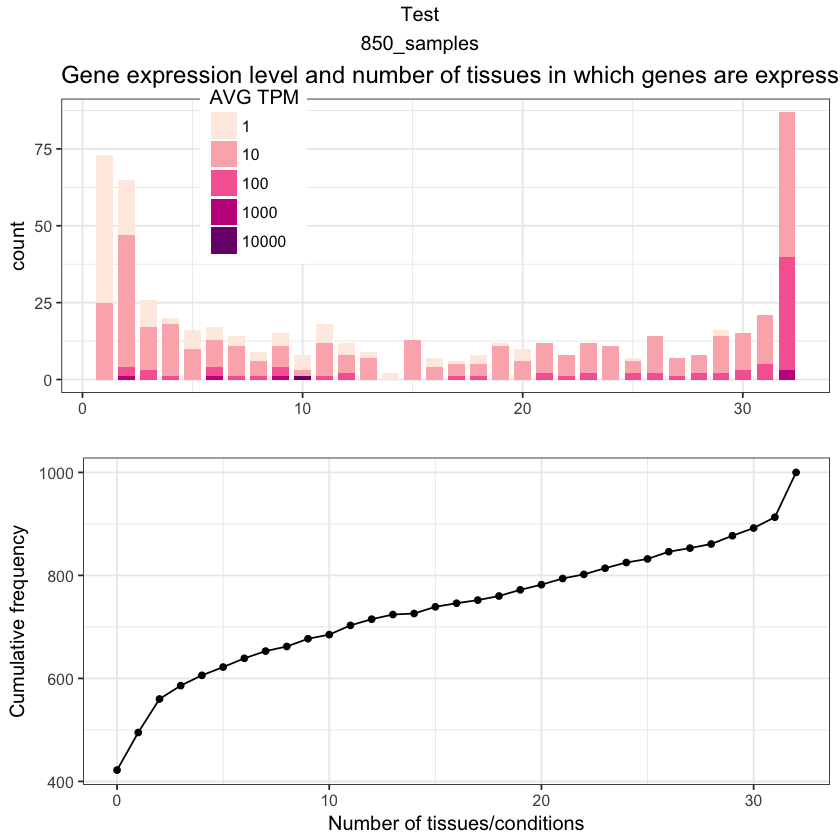

In [10]:
plot_all_means_filteredtpms_summary<-function(tpms, experiment="850_samples", min_tpm=0.5, title="Test"){
    
    local_title <- paste0(title, "\n", experiment)
    
    local_tpms<-subset(tpms, (subset == experiment) & 
                    factor == "all_mean_filter"  )
    
    
    
    breaks <- seq(-1,max(local_tpms$samples) , by = 1)
    samples.cut <- cut(local_tpms$samples, breaks, include.lowest = FALSE)
    samples.freq <- table(samples.cut)
    
    cumfreq0 =  cumsum(samples.freq)
    
    local_tpms<-subset(tpms, subset == experiment & 
                    factor == "all_mean_filter" & 
                       value > min_tpm)
    
    
    level <- ifelse(local_tpms$value < 0.1, 0.1, local_tpms$value) 
    level <- ceiling(log10(level))
    local_tpms$level <- level
    local_tpms$exp_max_value <- as.factor(10**level)
    
    gs<-list()
    gs[[length(gs)+1]] <- ggplot(local_tpms, aes(samples, fill = exp_max_value)) + 
        geom_bar(width = 0.75) +   scale_fill_brewer(palette="RdPu") + 
    ggtitle(paste0("Gene expression level and number of tissues in which genes are expressed")) + 
    theme_bw() +
    labs(fill="AVG TPM", x="") +
    theme(legend.position=c(.25,.75))+  
    guides(color = guide_legend(override.aes = list(size=5)))
    
    freqs_df <- data.frame(samples =  seq(0,max(local_tpms$samples) , by = 1), cum_freq=cumfreq0 )
    
    
    gs[[length(gs)+1]] <- ggplot(freqs_df, aes(samples, cum_freq)) +
     geom_line() + geom_point() + theme_bw() +
    labs(x="Number of tissues/conditions", y="Cumulative frequency")
    
    g1<-arrangeGrob(grobs=gs, ncol=1, top=local_title )
    g1
}
g<-plot_all_means_filteredtpms_summary(local_tpms)
grid.draw(g)

In [11]:
head(geneInformation$triadMovement)
head(geneInformation$triads)
colnames(geneInformation$triadMovement)

group_id,factor_count,central_total_distance,central_mean_distance,central_max_distance,central_sd_distance,central_max_over_mean,factor_total_distance,factor_mean_distance,factor_max_distance,⋯,total_categories,categories,Central,A.dominant,A.suppressed,B.dominant,B.suppressed,D.dominant,D.suppressed,dataset
293,7,0.6062345,0.08660492,0.2238081,0.06426540,2.584243,5.244827,0.1070373,0.2673542,⋯,1,Central,7,0,0,0,0,0,0,HC_CS_no_stress
402,14,1.3960438,0.09971741,0.2366306,0.05478721,2.373012,26.531690,0.1353658,0.3366594,⋯,2,"B.suppressed, Central",12,0,0,0,2,0,0,HC_CS_no_stress
412,14,1.7523738,0.12516956,0.3157323,0.08221177,2.522437,34.009908,0.1735199,0.5288915,⋯,2,"A.dominant, B.suppressed",0,9,0,0,5,0,0,HC_CS_no_stress
413,8,1.2148498,0.15185622,0.5967916,0.19715443,3.929978,14.582803,0.2278563,0.8372596,⋯,2,"A.suppressed, D.dominant",0,0,7,0,0,1,0,HC_CS_no_stress
437,14,1.2599138,0.08999384,0.2075839,0.05010373,2.306645,23.090914,0.1178108,0.2842241,⋯,2,"B.suppressed, Central",9,0,0,0,5,0,0,HC_CS_no_stress
451,15,2.1702923,0.14468615,0.3383461,0.09641904,2.338483,42.364965,0.1882887,0.4525514,⋯,2,"B.suppressed, Central",11,0,0,0,4,0,0,HC_CS_no_stress


,group_id,clust,description,general_description,Central,A.dominant,B.dominant,D.dominant,A.suppressed,B.suppressed,⋯,factor,gene,samples,chr_group,triad_sum,normalised_triad,Distance,P.rank,min_triad_sum,dataset
46984,293,1,Central,Central,0.15204590,0.9234479,0.8776336,0.6680248,0.3290121,0.3866607,⋯,aleurone,TraesCS7A01G542500,6,A,1.647199,0.2518310,0.15016255,0.42742604,0.5,HC_CS_no_stress
46985,293,1,Central,Central,0.15204590,0.9234479,0.8776336,0.6680248,0.3290121,0.3866607,⋯,aleurone,TraesCS7B01G464400,6,B,1.647199,0.2930886,0.15016255,0.42742604,0.5,HC_CS_no_stress
46986,293,1,Central,Central,0.15204590,0.9234479,0.8776336,0.6680248,0.3290121,0.3866607,⋯,aleurone,TraesCS7D01G527700,6,D,1.647199,0.4550804,0.15016255,0.42742604,0.5,HC_CS_no_stress
46987,402,1,Central,Central,0.03985017,0.8484215,0.8220579,0.7804268,0.3773891,0.4055151,⋯,aleurone,TraesCS4A01G184700,6,A,6.314192,0.3075345,0.03650501,0.04561792,0.5,HC_CS_no_stress
46988,402,1,Central,Central,0.03985017,0.8484215,0.8220579,0.7804268,0.3773891,0.4055151,⋯,aleurone,TraesCS4B01G134000,6,B,6.314192,0.3295545,0.03650501,0.04561792,0.5,HC_CS_no_stress
46989,402,1,Central,Central,0.03985017,0.8484215,0.8220579,0.7804268,0.3773891,0.4055151,⋯,aleurone,TraesCS4D01G128900,6,D,6.314192,0.3629111,0.03650501,0.04561792,0.5,HC_CS_no_stress


[1] "group_id"               "factor_count"           "central_total_distance"
 [4] "central_mean_distance"  "central_max_distance"   "central_sd_distance"   
 [7] "central_max_over_mean"  "factor_total_distance"  "factor_mean_distance"  
[10] "factor_max_distance"    "factor_sd_distance"     "factor_max_over_mean"  
[13] "category"               "sum_mean_tpm"           "total_categories"      
[16] "categories"             "Central"                "A.dominant"            
[19] "A.suppressed"           "B.dominant"             "B.suppressed"          
[22] "D.dominant"             "D.suppressed"           "dataset"

In [12]:
get_triads_from_genes<-function(genes, geneInformation, dataset="HC_CS_no_stress" , min_no_genes = 1){
    triads<-geneInformation$triads
    triadMovement<-geneInformation$triadMovement
    triads_with_genes <- triads[triads$gene %in% genes,]
    tridas_with_genes <- triads_with_genes[triads_with_genes$dataset == dataset,]
    genes_in_triads<-sqldf("SELECT group_id, gene FROM triads_with_genes GROUP BY gene") 
    triad_gene_count<-sqldf("SELECT group_id, count(*) as count from genes_in_triads GROUP BY group_id")
    group_ids <- triad_gene_count[triad_gene_count$count >= min_no_genes, "group_id"]
    list(triads=triads[triads$group_id %in% group_ids & triads$dataset==dataset,], 
        triadMovement=triadMovement[triadMovement$group_id %in% group_ids & triadMovement$dataset==dataset ,])
    
}
local_triads <- get_triads_from_genes(genes_to_plot, geneInformation, min_no_genes=2)
head(local_triads$triads)
nrow(local_triads$triads)
local_triads <- get_triads_from_genes(genes_to_plot, geneInformation, min_no_genes=1)
head(local_triads$triads)
nrow(local_triads$triads)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”

group_id,clust,description,general_description,Central,A.dominant,B.dominant,D.dominant,A.suppressed,B.suppressed,⋯,factor,gene,samples,chr_group,triad_sum,normalised_triad,Distance,P.rank,min_triad_sum,dataset


[1] 0

,group_id,clust,description,general_description,Central,A.dominant,B.dominant,D.dominant,A.suppressed,B.suppressed,⋯,factor,gene,samples,chr_group,triad_sum,normalised_triad,Distance,P.rank,min_triad_sum,dataset
47284,2976,5,A.suppressed,Suppressed,0.3318887,1.1474090,0.6821806,0.7405624,0.08307549,0.6576397,⋯,aleurone,TraesCS1A01G096400,6,A,2.607772,0.0634514,0.3234078,0.7619574,0.5,HC_CS_no_stress
47285,2976,5,A.suppressed,Suppressed,0.3318887,1.1474090,0.6821806,0.7405624,0.08307549,0.6576397,⋯,aleurone,TraesCS1B01G127300,6,B,2.607772,0.4890399,0.3234078,0.7619574,0.5,HC_CS_no_stress
47286,2976,5,A.suppressed,Suppressed,0.3318887,1.1474090,0.6821806,0.7405624,0.08307549,0.6576397,⋯,aleurone,TraesCS1D01G105400,6,D,2.607772,0.4475087,0.3234078,0.7619574,0.5,HC_CS_no_stress
48346,5336,1,Central,Central,0.2027042,0.9713371,0.6235300,0.8893152,0.29972583,0.6059609,⋯,aleurone,TraesCS3A01G159100,6,A,1.900738,0.2154466,0.1938176,0.5452032,0.5,HC_CS_no_stress
48347,5336,1,Central,Central,0.2027042,0.9713371,0.6235300,0.8893152,0.29972583,0.6059609,⋯,aleurone,TraesCS3B01G190000,6,B,1.900738,0.4927997,0.1938176,0.5452032,0.5,HC_CS_no_stress
48348,5336,1,Central,Central,0.2027042,0.9713371,0.6235300,0.8893152,0.29972583,0.6059609,⋯,aleurone,TraesCS3D01G166600,6,D,1.900738,0.2917538,0.1938176,0.5452032,0.5,HC_CS_no_stress


[1] 7263

In [13]:
unique(local_triads$triads$min_triad_sum)

[1] 0.5

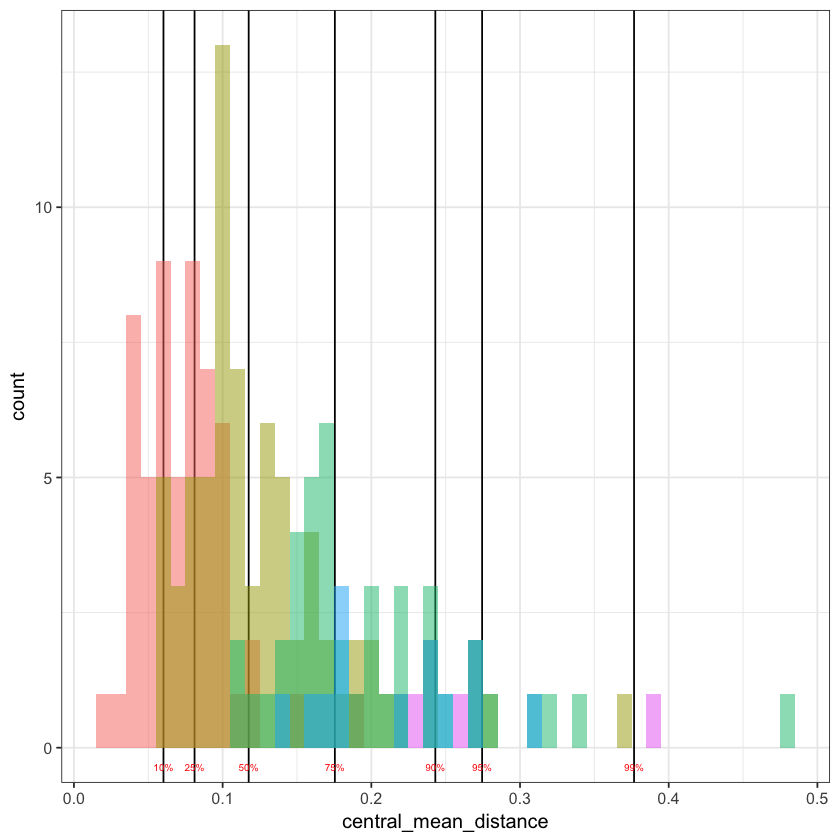

In [14]:
plot_distribution_for_factor<-function(res, unit="central_mean_distance" ,color_by="total_categories"){
    #unit<-paste0(from,"_",unit)
    
    local_res<-res[res$factor_count>1,c(unit, color_by)]
    local_res[,2]<-as.factor(local_res[,2])
    probs <- c( 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99)
    
    quantiles <- data.frame(quantile(local_res[,1], prob=probs,na.rm=TRUE), stringsAsFactors=FALSE)
    quantiles$quant<-rownames(quantiles)
    colnames(quantiles)<-c("value", "quant")
    #print(quantiles)
    local_res<-local_res[order(local_res[,color_by], decreasing = F),]
    
    
    p <- ggplot(local_res,aes_string(unit, fill=color_by)) +
    geom_vline(data=quantiles,aes(xintercept=quantiles$value) ) #
    for(i in seq(1,nrow(quantiles))){
        x_pos<-quantiles$value[i]
         gtext <- textGrob(quantiles$quant[i], y=0.02,  gp = gpar(fontsize = 6,col = "red"))
         p <- p + annotation_custom(gtext, xmin=x_pos, xmax=x_pos)
    }
    p <- p + theme_bw()
    #p <- p + geom_text(data = quantiles, mapping = aes_string(label = "quant", y = 0)) #, mapping = aes(label = quant, y = 0))
    p <- p + geom_histogram(position = "identity",alpha=0.5,binwidth=0.01) + theme(legend.position="none")
    p
}
plot_distribution_for_factor(local_triads$triadMovement)

Warning message:
“Removed 58 rows containing non-finite values (stat_bin).”Warning message:
“Removed 1 rows containing missing values (geom_vline).”Warning message:
“Removed 7 rows containing non-finite values (stat_bin).”Warning message:
“Removed 7 rows containing non-finite values (stat_bin).”Warning message:
“Removed 19 rows containing non-finite values (stat_bin).”Warning message:
“Removed 1 rows containing missing values (geom_vline).”Warning message:
“Removed 6 rows containing missing values (geom_bar).”

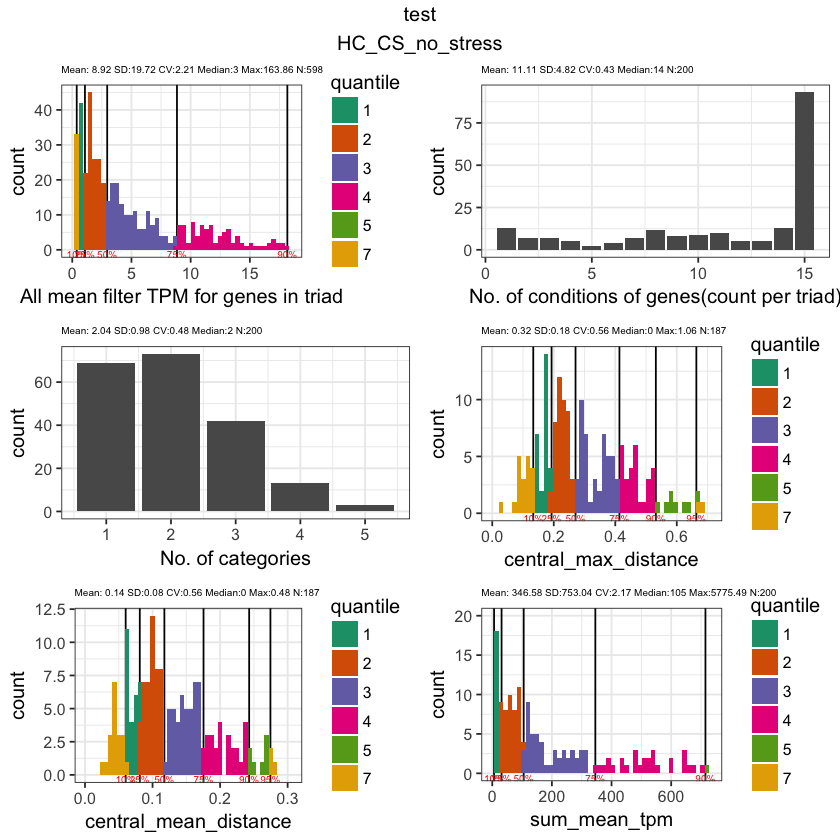

In [15]:
get_stats_title<-function(d){
    paste0("Mean: ", round(mean(d),2), 
                           " SD:", round(sd(d),2),
                           " CV:", round(sd(d)/mean(d), 2), 
                           " Median:", round(median(d),2),
                           " N:", length(d)) 
}


plot_dominance_summary<-function(selected_triads, experiment="HC_CS_no_stress", title="test"){
     local_title <- paste0(title, "\n", experiment)
    
    triads <- selected_triads$triads 
    triadMovement<-selected_triads$triadMovement
    
    all_means_filter<-triads[triads$factor=="all_mean_filter",]
    #print(unique(triads$factor))
    gs<-list()
    gs[[length(gs)+1]] <- plotHistogram(all_means_filter, column="value") + 
    xlab("All mean filter TPM for genes in triad")
    
    gs[[length(gs)+1]] <- ggplot(triadMovement, aes(factor_count)) +  geom_bar() + theme_bw() +
    #gs[[length(gs)+1]] <- plotHistogram(triadMovement, column="factor_count") + 
    xlab("No. of conditions of genes(count per triad)") +
    ggtitle(get_stats_title(triadMovement$factor_count)) + theme(plot.title = element_text(size=6))
   
    
    
   
    p <- ggplot(triadMovement, aes(total_categories)) + geom_bar() + theme_bw()
   # p <- plotHistogram(triadMovement, column="total_categories")
    p <- p + labs(fill="Main\ncategory", x="No. of categories") +
    ggtitle(get_stats_title(triadMovement$total_categories)) + theme(plot.title = element_text(size=6))
   
    gs[[length(gs)+1]] <- p
    
    gs[[length(gs)+1]] <- plotHistogram(triadMovement, column="central_max_distance")
    gs[[length(gs)+1]] <- plotHistogram(triadMovement, column="central_mean_distance")
    gs[[length(gs)+1]] <- plotHistogram(triadMovement, column="sum_mean_tpm")
    g1<-arrangeGrob(grobs=gs, ncol=2, top=local_title )
    g1
}
g<-plot_dominance_summary(local_triads)
grid.draw(g)
ggsave("test.pdf", plot=g , width = 210, height = 297, units = "mm")

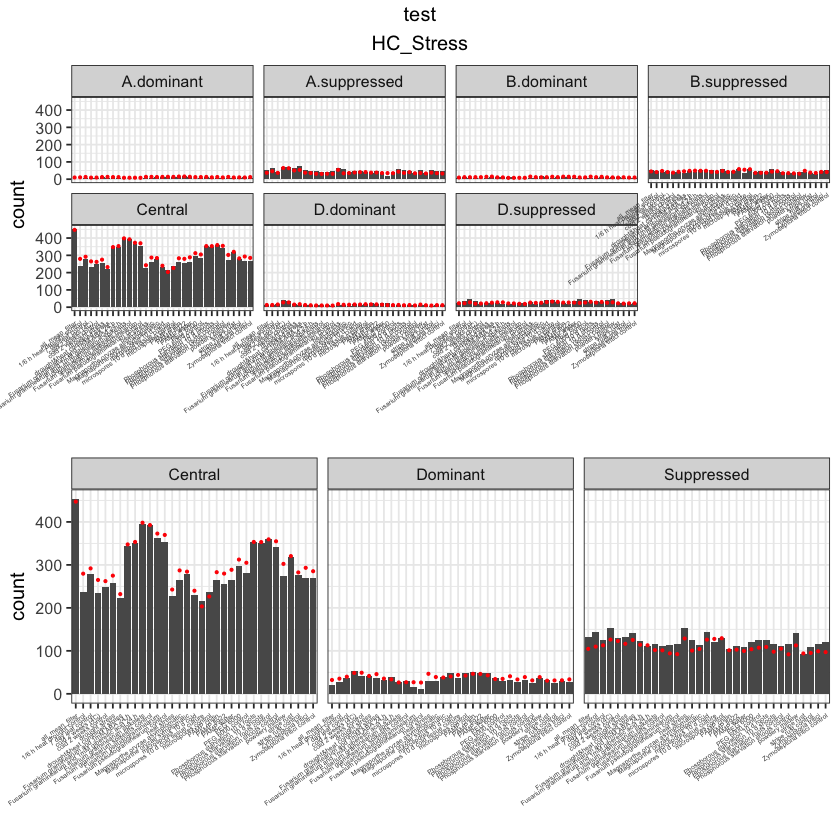

In [16]:
get_dominance_summary_tables_per_factor<-function(selected_triads, 
                                                  description = "description",
                                                  experiment="HC_CS_no_stress"){
    triads <- selected_triads$triads
    triads <- triads[triads$dataset==experiment, ]
    
    query <- paste0("SELECT factor, " , description , " as description, count(*) as count FROM triads GROUP BY factor, " , description )
    #print(query)
    table <- sqldf(query)
    table$percentage <- round(100 *  table$count / sum(table$count),2)
    
    casted <- dcast(table, factor  ~  description , value.var="count")
    rownames(casted) <- casted$factor
    casted$factor <- NULL
    percentage <-  100 * casted / rowSums(casted) 
    
    pasted<-matrix(paste(as.matrix(round(casted,2)),
                         as.matrix(round(percentage,2)) , sep=" - "),
                   nrow=nrow(casted), 
                   dimnames=dimnames(casted))
    pasted<-matrix(paste0(pasted, "%"),
                   nrow=nrow(casted), 
                   dimnames=dimnames(casted))
    
    list(long=table, casted=casted, percentage=percentage, pasted=pasted)
}

table_with_title<-function(title, table){
    
    
     mytheme <- gridExtra::ttheme_default(
         core = list(fg_params=list(cex = 0.5)),
         colhead = list(fg_params=list(cex = 0.5)),
         rowhead = list(fg_params=list(cex = 0.5)))
    
    t1 <- tableGrob(table, theme=mytheme)
    
    title2 <- textGrob(title, gp=gpar(fontsize=10))
    table2 <- gtable_add_rows(
        t1, 
        heights = grobHeight(title2),
        pos = 0)
    table2 <- gtable_add_grob(
        table2, title2, 
        1, 1, 1, 
        ncol(table2))
    
    table2
}

plot_dominance_summary_tables<-function(selected_triads, 
                                        expected_desc,
                                        expected_gen_desc,
                                        experiment="HC_CS_no_stress", title="test"){
    local_title <- paste0(title, "\n", experiment)
    
    triads <- selected_triads$triads 
    #triadMovement<-selected_triads$triadMovement
    
    expected_triads_desc<-expected_desc$long
    total_genes<-sum(expected_triads_desc$count)
    multiplier<-nrow(triads) / total_genes
    expected_triads_desc$exp_count <-  expected_triads_desc$count * multiplier
    
    expected_triads_gen_desc<-expected_gen_desc$long
    total_genes<-sum(expected_triads_gen_desc$count)
    multiplier<-nrow(triads) / total_genes
    expected_triads_gen_desc$exp_count <-  expected_triads_gen_desc$count * multiplier
    expected_triads_gen_desc$general_description <- expected_triads_gen_desc$description
    
    gs <- list()
    p <- ggplot(triads, aes(factor)) + geom_bar() + theme_bw()
    p <- p + theme(axis.text.x = element_text(angle = 35, hjust = 1, size=4)) + labs(fill="", x="")
    p <- p + theme(legend.text=element_text(size=5))+
    theme(legend.title=element_text(size=6)) + facet_wrap(~ description, ncol=4) 
    theme(legend.key.size = unit(0.4,"line"))
    
    p <- p + geom_point(data=expected_triads_desc, 
                        aes(x=factor, y=exp_count), color="red", size = 0.5)
    
    gs[[length(gs)+1]] <- p
    
    p <- ggplot(triads, aes(factor)) + geom_bar() + theme_bw()
    p <- p + theme(axis.text.x = element_text(angle = 35, hjust = 1, size=4)) + labs(fill="", x="")
    p <- p + theme(legend.text=element_text(size=5))+
    theme(legend.title=element_text(size=6))+
    theme(legend.key.size = unit(0.4,"line"))+ facet_wrap(~ general_description, ncol=3) 
   
    p <- p + geom_point(data=expected_triads_gen_desc, 
                        aes(x=factor, y=exp_count), color="red", size = 0.5)
    
    gs[[length(gs)+1]] <- p
       
    g1<-arrangeGrob(grobs=gs, ncol=1, top=local_title )
    g1
}

dataset="HC_Stress"
expected_desc<-get_dominance_summary_tables_per_factor(geneInformation, experiment=dataset)
expected_gen_desc<-get_dominance_summary_tables_per_factor(geneInformation,
                                                           description="general_description",
                                                           experiment=dataset)
   

local_triads <- get_triads_from_genes(genes_to_plot, geneInformation, dataset=dataset)
g<-plot_dominance_summary_tables(local_triads,expected_desc, expected_gen_desc, experiment=dataset  )
grid.draw(g)
ggsave("test.pdf", plot=g , width = 210, height = 297, units = "mm")

In [17]:
get_goseq_enrichment<-function(geneInformation, genes_to_plot, 
                               name="Random Samples",
                               dataset="HC_CS_no_stress", 
                               ontology="GO"
                              ){
    id_names <- geneInformation$id_names
    universe<-geneInformation$gene_universe 
    universe<-universe[universe$dataset==dataset,]
    #print(nrow(universe))
    if(nrow(universe) == 0) {
        return (data.frame(category= numeric(0), 
                          over_represented_pvalue= numeric(0),
                          under_represented_pvalue= numeric(0),
                          numDEInCat= numeric(0),
                          numInCat= numeric(0),
                          ontology= numeric(0),
                          over_rep_padj= numeric(0),
                          under_rep_padj= numeric(0),
                          description= numeric(0),
                          universe_size= numeric(0)
                         ))
    }
    ontologies<-geneInformation$ontologies
    ontologies<-ontologies[ontologies$ontology==ontology,]
    
    assayed.genes <- as.vector(universe$gene)
    gene.vector=as.integer(assayed.genes%in%genes_to_plot)
    names(gene.vector)=assayed.genes
    
    transcripts<-geneInformation$canonicalTranscripts
    lengths <- transcripts[,c("Gene", "exon_length")]
    
    colnames(lengths) <- c("gene", "length")
    t1 <- subset(lengths, gene %in% universe$gene)
    gene.lens <- as.numeric(t1$length)
    names(gene.lens) = t1$gene
    
    all_go <- subset(ontologies, Gene %in% universe$gene)
    all_go<-all_go[,c(1,2)]
    
    pwf = nullp(gene.vector, bias.data = gene.lens, plot.fit = FALSE)
    GO.wall = goseq(pwf, gene2cat = all_go)
    
    #this gave table with p-values...now correct for multiple testing using FDR
    # add new column with over represented GO terms padj
    GO.wall$over_rep_padj=p.adjust(GO.wall$over_represented_pvalue, method="BY")
    # add new column with under represented GO terms padj
    GO.wall$under_rep_padj=p.adjust(GO.wall$under_represented_pvalue, method="BY")
  
    # now select only GO terms where the padj is <0.05 for either enriched or under represented
    sig.GO <- GO.wall[GO.wall$over_rep_padj <0.05 | GO.wall$under_rep_padj <0.05,]
    sig.GO <- sig.GO[order(sig.GO$over_rep_padj),]
    if(nrow(sig.GO) == 0 ){
        return (data.frame(category= numeric(0), 
                          over_represented_pvalue= numeric(0),
                          under_represented_pvalue= numeric(0),
                          numDEInCat= numeric(0),
                          numInCat= numeric(0),
                          ontology= numeric(0),
                          over_rep_padj= numeric(0),
                          under_rep_padj= numeric(0),
                          description= numeric(0),
                          universe_size= numeric(0)
                         ))
    }
    
    sig.GO2 <- merge(sig.GO, id_names, by.x="category", by.y="V1", all.x =TRUE, all.y =FALSE)
   
    if( nrow(sig.GO) > 0 && (ontology == "PO" || ontology == "TO" )){
        sig.GO2$ontology<-ontology
    }
    
    sig.GO <-sig.GO2[,c('category','over_represented_pvalue','under_represented_pvalue','numDEInCat','numInCat',
    'ontology','over_rep_padj','under_rep_padj','V2')]
    
    colnames(sig.GO)<-c('category','over_represented_pvalue','under_represented_pvalue','numDEInCat','numInCat',
    'ontology','over_rep_padj','under_rep_padj','description')
    
    sig.GO$type<-ifelse(sig.GO$under_rep_padj > sig.GO$over_rep_padj,
                        "Over represented", 
                        "Under represented" )
    sig.GO$p_adjust<-ifelse(sig.GO$under_rep_padj > sig.GO$over_rep_padj,
                            sig.GO$over_rep_padj, 
                            sig.GO$under_rep_padj )
    sig.GO$percentage<- round(100 * sig.GO$numDEInCat/sig.GO$numInCat,2)
    
    
    sig.GO

}


enrichment_test<- get_goseq_enrichment(geneInformation, genes_to_plot,  ontology="GO") 
#enrichment_test_po<- get_goseq_enrichment(geneInformation, genes_to_plot,  ontology="PO") 
#enrichment_test_to<- get_goseq_enrichment(geneInformation, genes_to_plot,  ontology="TO") 
#enrichment_test<-rbind(enrichment_test,enrichment_test_po)
#enrichment_test<-rbind(enrichment_test,enrichment_test_to)
nrow(enrichment_test)
enrichment_test<- get_goseq_enrichment(geneInformation, genes_to_plot,  ontology="GO", dataset="HC_stress") 
#enrichment_test_po<- get_goseq_enrichment(geneInformation, genes_to_plot,  ontology="PO", dataset="HC_Cstress") 
#enrichment_test_to<- get_goseq_enrichment(geneInformation, genes_to_plot,  ontology="TO", dataset="HC_Cstress") 
#enrichment_test<-rbind(enrichment_test,enrichment_test_po)
#enrichment_test<-rbind(enrichment_test,enrichment_test_to)
nrow(enrichment_test)

Using manually entered categories.
For 2987 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


[1] 0

[1] 0

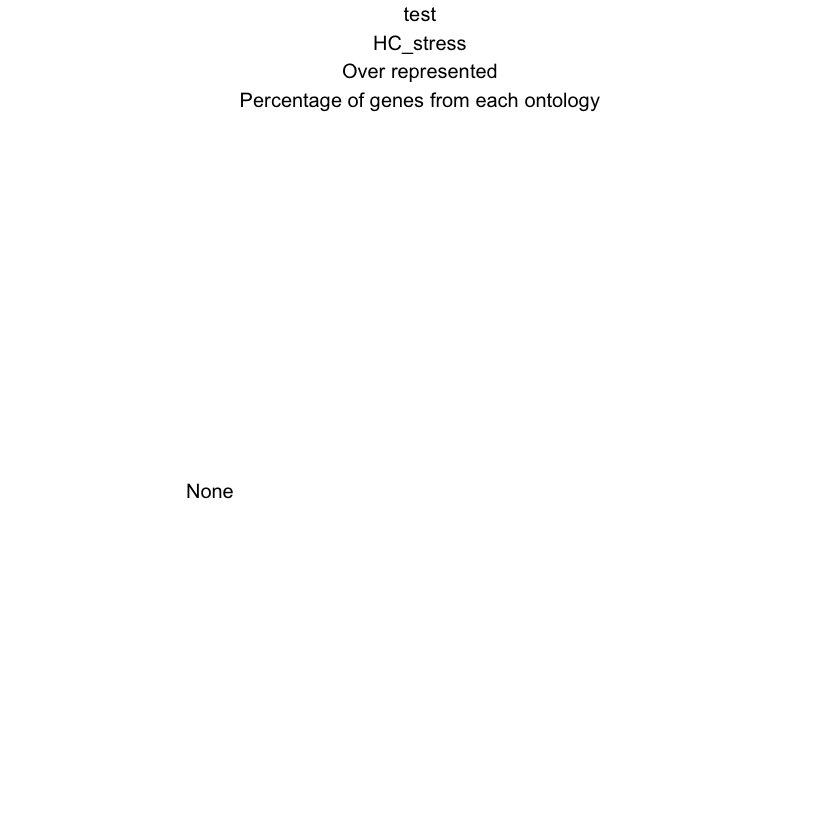

In [18]:
plot_enrichment<-function(enrichment,experiment="HC_CS_no_stress", title="test" , type="Over represented"){
    local_title <- paste0(title, "\n", experiment, "\n", type , "\nPercentage of genes from each ontology\n")
    gs<-list()
    for(ont in unique(enrichment$ontology)){
        current<-enrichment[enrichment$ontology == ont & enrichment$type == type, ]
        if(nrow(current) > 0){
            gs[[length(gs)+1]] <- ggplot(current, aes(description, percentage)) + 
            coord_flip() +
            geom_col(fill="#a8ddb5") + labs(y="", x="", title=ont) +  theme_bw() + #ylim(0,100) + 
            theme(axis.text.x = element_text(angle = 0, hjust = 1, size=4),
             axis.text.y = element_text(angle = 35, hjust = 1, size=4))  +
            geom_text(aes(label=numDEInCat), position=position_dodge(width=0.9), size=3)
        }
    }
    if(length(gs) == 0){
        gs[[length(gs)+1]] <- textGrob("None")
    }
    g1<-arrangeGrob(grobs=gs, ncol=2, top=local_title )
}
g<-plot_enrichment(enrichment_test, type="Over represented", experiment="HC_stress")
grid.draw(g)

In [19]:
plot_gene_summary<-function(geneInformation, genes_to_plot, name="Random Samples" , output_path="./Test"){
    local_table<-geneInformation$canonicalTranscripts
    local_table<-local_table[local_table$Gene %in% genes_to_plot,]
    
    local_mean_tpms<-geneInformation$meanTpms
    local_mean_tpms<-local_mean_tpms[local_mean_tpms$gene %in% genes_to_plot, ]
    
    stats_to_plot<-c('size_cds', 'exon_no', 'exon_length','intron_length', 'X3UTR_length', 'X5UTR_length' )
    
    
    expected_per_chr<-get_expected_values(geneInformation$canonicalTranscripts, nrow(local_table))
    
    gs<-list()
    plots<-list()
    
    plots[[length(plots)+1]] <- textGrob(paste0(name, " Gene summary"))
    for(plot in stats_to_plot){
        p<-plotHistogram(local_table,column=plot)
        gs[[length(gs)+1]] <- p
    }
    plots[[length(plots)+1]] <- arrangeGrob(grobs=gs, ncol=2 , top = paste0(name, "\n Gene properties"))
    plots[[length(plots)+1]] <- plot_per_chromosome_5pc_bins_facet(local_table,
                                                                   expected_per_chr=expected_per_chr, 
                                                                   title=name)
    
    plots[[length(plots)+1]] <- textGrob(paste0(name, " TPM summary"))
    for(s in unique(geneInformation$meanTpms$subset)){
        plots[[length(plots)+1]] <- plot_tpms_summary(local_mean_tpms, experiment=s, title=name) 
        plots[[length(plots)+1]] <- plot_tpm_desc_stats(geneInformation$meanTpms, local_mean_tpms, experiment=s, title=name)
        plots[[length(plots)+1]] <- plot_all_means_filteredtpms_summary(local_mean_tpms, experiment=s, title=name) 
    }
    
    plots[[length(plots)+1]] <- textGrob(paste0(name, " Triad summary"))
    for(s in unique(geneInformation$triads$dataset)){
        for(i in c(1,2,3)){
            local_triads <- get_triads_from_genes(genes_to_plot, geneInformation, dataset=s, min_no_genes = i)
            if(nrow(local_triads$triads)== 0){
                next
            }
            name_tmp <-name
            name <- paste0(name, " Min genes in triad: ", i )
            #print("About to plot for ")
            #print(name)
            #print("Number of triads:")
            #print(nrow(local_triads$triads))
            plots[[length(plots)+1]] <- plot_dominance_summary(local_triads, experiment=s, title=name)
        
            expected_desc    <-get_dominance_summary_tables_per_factor(geneInformation, experiment=s)
            expected_gen_desc<-get_dominance_summary_tables_per_factor(geneInformation,
                                                           description="general_description",
                                                           experiment=s)
        
            observed_desc    <-get_dominance_summary_tables_per_factor(geneInformation, experiment=s)
            observed_gen_desc<-get_dominance_summary_tables_per_factor(geneInformation,
                                                           description="general_description",
                                                           experiment=s)
        
             plots[[length(plots)+1]] <-plot_dominance_summary_tables(local_triads,
                                                                  expected_desc, 
                                                                  expected_gen_desc, 
                                                                  experiment=s, title=name  )
        
        
            plots[[length(plots)+1]] <- table_with_title(paste(name, s, "Observed"),
                                                    observed_desc$pasted
                                                    )
             plots[[length(plots)+1]] <- table_with_title(paste(name, s, "Expected"),
                                                    expected_desc$pasted
                                                    )
        
            plots[[length(plots)+1]] <- table_with_title(paste(name, s, "Observed"),
                                                   observed_gen_desc$pasted
                                                    )
             plots[[length(plots)+1]] <- table_with_title(paste(name, s, "Expected"),
                                                    expected_gen_desc$pasted
                                                    )
            }
        name<-name_tmp
        
        
    }
    
    plots[[length(plots)+1]] <- textGrob(paste0(name, " Go enrichment"))                                     
    
    
    all_enrichments <- NULL
    for(g_u in unique(geneInformation$gene_universe$dataset)){
        enrichment_test<- get_goseq_enrichment(geneInformation, genes_to_plot,  ontology="GO" , dataset=g_u) 
        enrichment_test_po<- get_goseq_enrichment(geneInformation, genes_to_plot,  ontology="PO" , dataset=g_u) 
        enrichment_test_to<- get_goseq_enrichment(geneInformation, genes_to_plot,  ontology="TO" , dataset=g_u) 
        enrichment_test<-rbind(enrichment_test,enrichment_test_po)
        enrichment_test<-rbind(enrichment_test,enrichment_test_to)
        if(nrow(enrichment_test) == 0){
            next
        }
        enrichment_test$universe<-g_u
        
        for(type in unique(enrichment_test$type)){
            plots[[length(plots)+1]] <- plot_enrichment(enrichment_test,
                                                        experiment=g_u, 
                                                        title=name, 
                                                        type=type)
        }
        if(is.null(all_enrichments)){
            all_enrichments <- enrichment_test
        }else{
            all_enrichments<-rbind(all_enrichments, enrichment_test)
        }
    }
    
    dir<-paste0(output_path,"/",name)
    dir.create(dir, showWarnings = FALSE, recursive = TRUE)
    
    output_enrichment<-paste0(dir, "/", "enrichment.csv")
    write.csv(all_enrichments, file=output_enrichment)
    output_pdf<-paste0(dir, "/",name ,".pdf")
    
    
    g1<-marrangeGrob(plots, ncol=1, nrow=1, top="", bottom = quote(paste("page", g, "of",
       pages)))
    
    ggsave(output_pdf, plot=g1 , width = 210, height = 297, units = "mm")
    g1
}
g<-plot_gene_summary(geneInformation,genes_to_plot, name="Random 1000 samples" )


Warning message:
“Removed 72 rows containing non-finite values (stat_bin).”Warning message:
“Removed 1 rows containing missing values (geom_vline).”Warning message:
“Removed 104 rows containing non-finite values (stat_bin).”Warning message:
“Removed 2 rows containing missing values (geom_vline).”Warning message:
“Removed 64 rows containing non-finite values (stat_bin).”Warning message:
“Removed 1 rows containing missing values (geom_vline).”Warning message:
“Removed 47 rows containing non-finite values (stat_bin).”Warning message:
“Removed 1 rows containing missing values (geom_vline).”Warning message:
“Removed 19 rows containing non-finite values (stat_bin).”Warning message:
“Removed 1 rows containing missing values (geom_vline).”Warning message:
“Removed 27 rows containing non-finite values (stat_bin).”Warning message:
“Removed 1 rows containing missing values (geom_vline).”Warning message:
“Removed 9 rows containing non-finite values (stat_count).”Warning message:
“Removed 21 rows c

In [ ]:
for(set in unique(geneInformation$WGCNA$set)){
    local_set<-geneInformation$WGCNA[geneInformation$WGCNA$set == set,]
    for(module in unique(local_set$ModuleLabels)){
        name<-paste0(set,"_Module_",module)
        print(name)
        genes_to_plot<-local_set[local_set$ModuleLabels == module, "Gene"]
        print(head(genes_to_plot))
        print(length(genes_to_plot))
        
        write.csv(genes_to_plot, file=paste0("gene_set_files/",name,".txt"), row.names=F, col.names=F)
    }
}